In [1]:
import opendbpy as odb
import graph_tool.all as gt

In [2]:
lef_file_path = "designs/gscl45nm.lef"
def_file_path = "designs/design_sample.def"

In [3]:
def read_netlist(lef_file, def_file):
    # intialize the database
    db = odb.dbDatabase.create()

    # load the lef file
    try:
        odb.read_lef(db, lef_file)
    except Exception as e:
        print("Problem loading the tech file!")
        return None

    # load the def file
    try:
        odb.read_def(db, def_file)
    except Exception as e:
        print("Problem loading the design!")
        return None

    # parse the design into a DGL graph
    design = db.getChip()
    G = build_graph(design)

    print(str.format('Built a graph with %s nodes' % str(G.num_vertices())))
    print(str.format('.... Added %s edges' % str(G.num_edges())))

    return G

In [4]:
def build_graph(design, undirected=False, draw=True):
    '''
    Input: design is an OpenDB representation of the chip
    Returns: graph-tool Graph
    '''
    instances = design.getBlock().getInsts()
    pins = design.getBlock().getBTerms()

    # initialize graph
    g = gt.Graph(directed=not undirected)

    # graph-tool can use string vertex properties, so we don't need a separate mapping
    v_name = g.new_vertex_property("string")
    g.vertex_properties["name"] = v_name
    v_color = g.new_vertex_property("string")
    g.vertex_properties["color"] = v_color
    v_inst = g.new_vertex_property("boolean")
    g.vertex_properties["is_inst"] = v_inst
    v_width = g.new_vertex_property("float")
    g.vertex_properties["width"] = v_width
    v_height = g.new_vertex_property("float")
    g.vertex_properties["height"] = v_height
    
    # Add vertices
    print("Reading Instances...")
    for inst in instances:
        v = g.add_vertex()
        v_name[v] = inst.getName()
        v_color[v] = "#007dff"
        v_inst[v] = True
        #v_width[v] = inst.getWidth()
        #v_height[v] = inst.getHeight()
        print("{} : {}".format(g.num_vertices() - 1, inst.getName()))

    print("Reading Pins...")
    for pin in pins:
        v = g.add_vertex()
        v_name[v] = pin.getName()
        v_color[v] = "#ff7c44"
        v_inst[v] = False
        print("{} : {}".format(g.num_vertices() - 1, inst.getName()))


    nets = design.getBlock().getNets()
    for net in nets:
        # exclude power nets
        if net.isSpecial():
            continue

        iterms = net.getITerms()
        bterms = net.getBTerms()

        # given a net, figure out the driving cell and the loads
        driving_cell = None
        loads = []

        # if iterm, then it needs to have direction output to be a driving cell
        for iterm in iterms:
            if iterm.getIoType() == 'OUTPUT':
                driving_cell = iterm.getInst().getName()
            else:
                loads.append(iterm.getInst().getName())
        
        # if bterm, then it needs to have direction input to be a driving cell
        for bterm in bterms:
            if bterm.getIoType() == 'INPUT':
                assert (driving_cell == None), "Something is wrong with the directions!"
                driving_cell = bterm.getName()
            else:
                loads.append(bterm.getName())

        if (driving_cell == None):
            print(net.getName())
            continue
        assert (driving_cell != None), "Couldn't figure out the net directions"

        # add edges
        src = g.vertex(list(v_name).index(driving_cell))
        for load in loads:
            dst = g.vertex(list(v_name).index(load))
            g.add_edge(src, dst)

    if draw:
        gt.graph_draw(g, vertex_text=v_name, vertex_fill_color=v_color)

    return g

Reading Instances...
0 : _d0_
1 : _d1_
2 : _d2_
3 : _d3_
4 : _d4_
5 : _d5_
6 : _d6_
7 : _d7_
8 : _d8_
9 : _g0_
10 : _g1_
11 : _g2_
Reading Pins...
12 : _g2_
13 : _g2_
14 : _g2_
15 : _g2_
16 : _g2_
17 : _g2_
18 : _g2_
19 : _g2_
20 : _g2_
21 : _g2_
22 : _g2_
23 : _g2_
_xout0
_xout1
_xout2
_xout3
_xout4
_xout5
_xout6
_xout7
_xout8


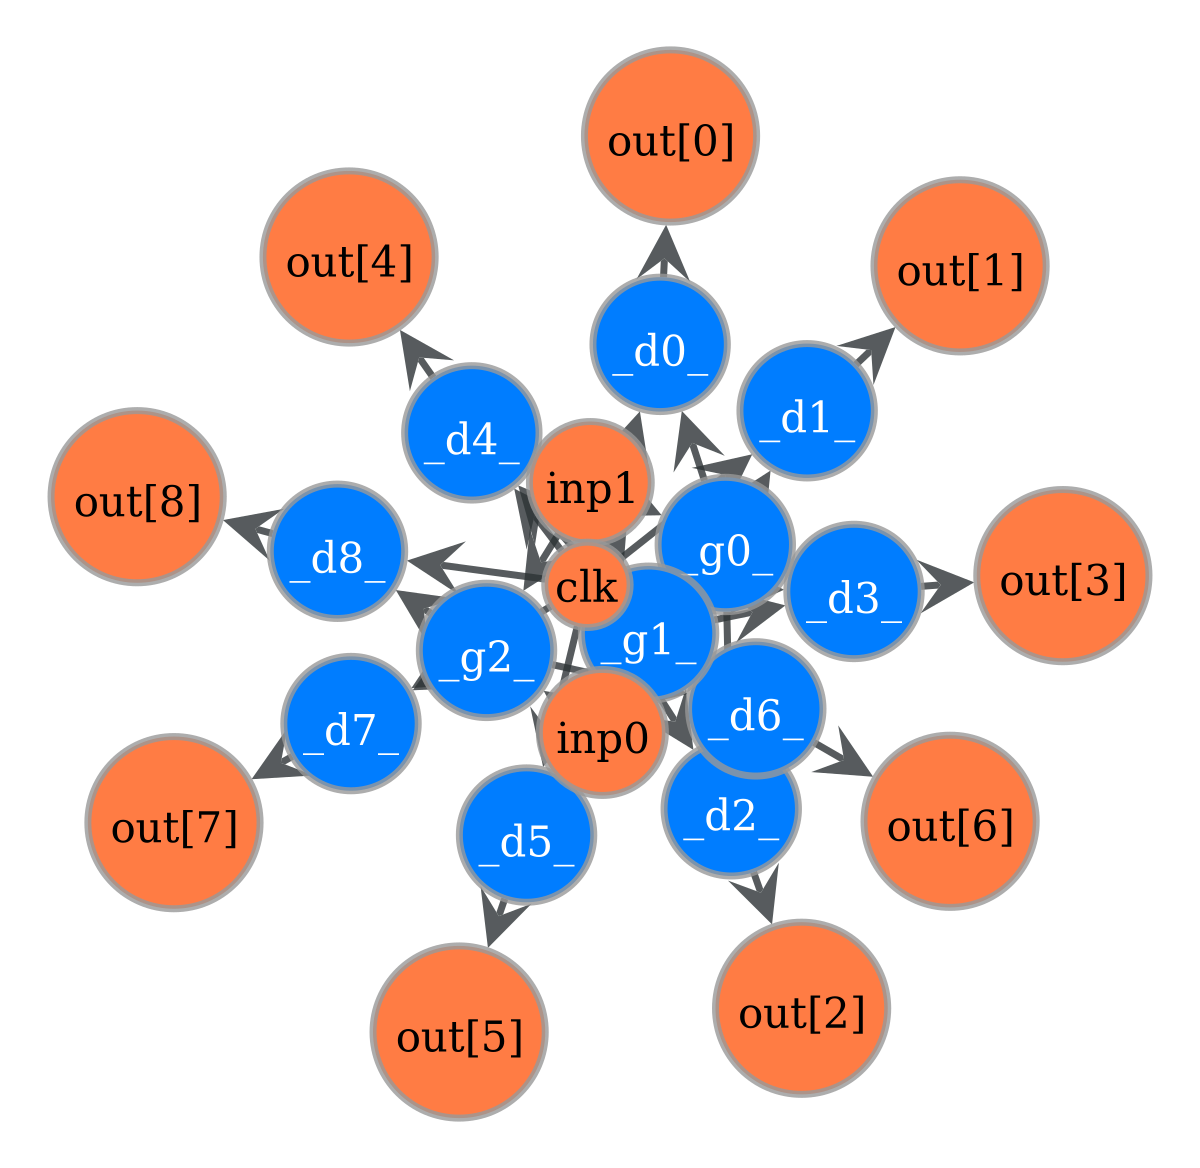

Built a graph with 24 nodes
.... Added 33 edges


In [5]:
G = read_netlist(lef_file_path, def_file_path)